## Thyroid Disease Detection End to End with Deployment


#### Importing important libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import skew


import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.api import add_constant


# import the train_test_split library
from sklearn.model_selection import train_test_split

# importing the SMOTE library
from imblearn.over_sampling import SMOTE

# ML classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


# performance parameters
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


#### Reading datasets: allhypo and allhyper

In [3]:
df_hypo = pd.read_csv('allhypo.data', header = None, index_col = False)
df_hyper = pd.read_csv('allhyper.data', header = None, index_col = False)


In [4]:
columns = ["age","sex","on thyroxine","query on thyroxine","on antithyroid medication","sick","pregnant",\
           "thyroid surgery","I131 treatment","query hypothyroid","query hyperthyroid","lithium","goitre",\
           "tumor","hypopituitary","psych","TSH measured","TSH","T3 measured","T3","TT4 measured","TT4",\
           "T4U measured","T4U","FTI measured","FTI","TBG measured","TBG","referral source","labels"]


df_hypo = pd.read_csv('allhypo.data', names = columns, na_values = ['?'], index_col = False)
df_hyper = pd.read_csv('allhyper.data', names = columns, na_values = ['?'], index_col = False)


#### Data Understanding and Data Preparation

Splitting the labels column at | into two columns: 'class' and 'id'.

After that dropping the labels column.

In [5]:
df_hypo[['hypo_class','id']] = df_hypo.labels.str.split("|",expand = True)
df_hypo.drop('labels', axis = 1, inplace = True)

df_hyper[['hyper_class','id']] = df_hyper.labels.str.split("|",expand = True)
df_hyper.drop('labels', axis = 1, inplace = True)


Replacing the '.' in 'class' column with space ('')


In [6]:
df_hypo['hypo_class'] = df_hypo['hypo_class'].str.replace('.', '')
df_hyper['hyper_class'] = df_hyper['hyper_class'].str.replace('.', '')


Deep copying both the datasets for future reference.


In [7]:
df_hypo_copy = df_hypo.copy(deep=True)
df_hyper_copy = df_hyper.copy(deep=True)


#### Checking total unique values in both dataset of the class 'hypo_class' and 'hyper_class'


In [8]:
print(df_hypo['hypo_class'].unique())
print(df_hyper['hyper_class'].unique())


['negative' 'compensated hypothyroid' 'primary hypothyroid'
 'secondary hypothyroid']
['negative' 'hyperthyroid' 'T3 toxic' 'goitre']


Since we are classifying only in three categories: 'negative', 'hypothyroid', and 'hyperthyroid'.

So, let's replace other values with 'negative', 'hypothyroid', and 'hyperthyroid'.

In [9]:
df_hypo.replace(['compensated hypothyroid', 'primary hypothyroid',\
                 'secondary hypothyroid'], 'hypothyroid', inplace = True)

df_hyper.replace(['T3 toxic', 'goitre'], 'hyperthyroid', inplace = True)


Since all values are common in both the datasets expect 'class'.

So, we can concatnate both the datasets.

In [10]:
df_concat = pd.concat([df_hypo, df_hyper.iloc[:, -2]], axis=1)
df_concat.head()


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,hypo_class,id,hyper_class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,1.14,t,109.0,f,NaN,SVHC,negative,3733,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,f,NaN,f,NaN,f,NaN,other,negative,1442,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,0.91,t,120.0,f,NaN,other,negative,2965,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,f,NaN,f,NaN,f,NaN,other,negative,806,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,0.87,t,70.0,f,NaN,SVI,negative,2807,negative


Deep copying the concatnated dataset for future reference.

In [11]:
df_new = df_concat.copy(deep = True)

# df_concat.replace(['negative', 'hyperthyroid', 'hypothyroid'], [0,1,2], inplace = True)


Now, the conditions based on which we are replacing the 'class' value with any of the 'class' i.e. 'hypo_class' or 'hyper_class'

- neg + neg = neg
- hypo + neg = hypo
- hyper + neg = hyper

Applying the above conditions using 'numpy where' and creating a single column for categories, 'labels'.

In [12]:
df_concat['labels'] = np.where(((df_concat['hypo_class'] != 'negative') & \
                                (df_concat['hyper_class'] == 'negative')), df_concat['hypo_class'],\
                      np.where((df_concat['hyper_class'] != 'negative'), df_concat['hyper_class'],'negative'))


In [13]:
df_concat.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T4U,FTI measured,FTI,TBG measured,TBG,referral source,hypo_class,id,hyper_class,labels
0,41.0,F,f,f,f,f,f,f,f,f,...,1.14,t,109.0,f,NaN,SVHC,negative,3733,negative,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,other,negative,1442,negative,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,0.91,t,120.0,f,NaN,other,negative,2965,negative,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,other,negative,806,negative,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,0.87,t,70.0,f,NaN,SVI,negative,2807,negative,negative


Dopping those columns (features) which are not relevant and storing it in a new dataframe.

In [14]:
df = df_concat.drop(['referral source', 'TBG', 'hypo_class', 'id', 'hyper_class'], axis = 1)


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        2799 non-null   float64
 1   sex                        2690 non-null   object 
 2   on thyroxine               2800 non-null   object 
 3   query on thyroxine         2800 non-null   object 
 4   on antithyroid medication  2800 non-null   object 
 5   sick                       2800 non-null   object 
 6   pregnant                   2800 non-null   object 
 7   thyroid surgery            2800 non-null   object 
 8   I131 treatment             2800 non-null   object 
 9   query hypothyroid          2800 non-null   object 
 10  query hyperthyroid         2800 non-null   object 
 11  lithium                    2800 non-null   object 
 12  goitre                     2800 non-null   object 
 13  tumor                      2800 non-null   objec

#### Let's deep dive into few feature columns

In [16]:
df[['TSH measured', 'TSH']].tail(10)


,TSH measured,TSH
2790,t,2.10
2791,t,1.00
2792,f,NaN
2793,t,0.03
2794,t,1.90
2795,t,2.70
2796,f,NaN
2797,f,NaN
2798,t,1.40
2799,t,1.20


Some columns are just indicating whether next column in the same row has some value or not. Like 'TSH measured' have 'true' & 'false' value. 

The 'true' means, the next column in the same row has some value and 'false' means, next column in the same row has 'NaN'. So, we are any ways going to handle the missing values, there is no point of having such columns in our dataset.

Let's drop these feature columns.

In [17]:
df = df.drop(['TSH measured','T3 measured','TT4 measured','T4U measured',\
              'FTI measured','TBG measured'], axis = 1)


### Types of Data in the Dataset:

- categorical
    - nominal (order not matter)
    - ordinal (order matter)
    
URLs: 
- https://www.freecodecamp.org/news/types-of-data-in-statistics-nominal-ordinal-interval-and-ratio-data-types-explained-with-examples/
- https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/ 


- numerical
    - discrete (discrete data is counted)
    - continuous (continuous data is measured)

URLs:
- https://www.mathsisfun.com/data/data-discrete-continuous.html
- https://www.intellspot.com/discrete-vs-continuous-data/
     

In [18]:
cat_features = [i for i in df.columns if (df[i].dtype == 'O')]
cat_features

['sex',
 'on thyroxine',
 'query on thyroxine',
 'on antithyroid medication',
 'sick',
 'pregnant',
 'thyroid surgery',
 'I131 treatment',
 'query hypothyroid',
 'query hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych',
 'labels']

In [19]:
len(cat_features)

16

In [20]:
num_features = [i for i in df.columns if (df[i].dtype != 'O')]
num_features

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

In [21]:
len(num_features)

6

In [22]:
for i in cat_features:
    print('---'*20)
    print(i, 'feature: unique values: ', df[i].unique())
    
print('---'*20)


------------------------------------------------------------
sex feature: unique values:  ['F' 'M' nan]
------------------------------------------------------------
on thyroxine feature: unique values:  ['f' 't']
------------------------------------------------------------
query on thyroxine feature: unique values:  ['f' 't']
------------------------------------------------------------
on antithyroid medication feature: unique values:  ['f' 't']
------------------------------------------------------------
sick feature: unique values:  ['f' 't']
------------------------------------------------------------
pregnant feature: unique values:  ['f' 't']
------------------------------------------------------------
thyroid surgery feature: unique values:  ['f' 't']
------------------------------------------------------------
I131 treatment feature: unique values:  ['f' 't']
------------------------------------------------------------
query hypothyroid feature: unique values:  ['f' 't']
-------

In [23]:
for i in num_features:
    print('---'*12)
    print(i, 'feature: unique values: ', len(df[i].unique()))
    
print('---'*12)


------------------------------------
age feature: unique values:  94
------------------------------------
TSH feature: unique values:  264
------------------------------------
T3 feature: unique values:  65
------------------------------------
TT4 feature: unique values:  218
------------------------------------
T4U feature: unique values:  139
------------------------------------
FTI feature: unique values:  210
------------------------------------


In [24]:
for i in num_features:
    print('---'*12)
    print(i, 'feature: minimum value: ', min(df[i].unique()))
    print(i, 'feature: maximum value: ', max(df[i].unique()))
    
print('---'*12)


------------------------------------
age feature: minimum value:  1.0
age feature: maximum value:  455.0
------------------------------------
TSH feature: minimum value:  0.005
TSH feature: maximum value:  478.0
------------------------------------
T3 feature: minimum value:  0.05
T3 feature: maximum value:  10.6
------------------------------------
TT4 feature: minimum value:  2.0
TT4 feature: maximum value:  430.0
------------------------------------
T4U feature: minimum value:  0.31
T4U feature: maximum value:  2.12
------------------------------------
FTI feature: minimum value:  2.0
FTI feature: maximum value:  395.0
------------------------------------


#### Obeservations:
Categorical features: 15
- all are nominal data

Numerical features: 6
- discrete data: 1
- continous data: 5

#### Let's see some more insights of Categorical and Numerical Data

In [25]:
# numerical data
df.describe()


,age,TSH,T3,TT4,T4U,FTI
count,2799.00000,2516.000000,2215.000000,2616.000000,2503.000000,2505.000000
mean,51.84423,4.672150,2.024966,109.072401,0.997912,110.787984
std,20.46116,21.449453,0.824600,35.392443,0.194390,32.883986
min,1.00000,0.005000,0.050000,2.000000,0.310000,2.000000
25%,36.00000,0.440000,1.600000,88.000000,0.880000,93.000000
50%,54.00000,1.400000,2.000000,104.000000,0.980000,107.000000
75%,67.00000,2.600000,2.400000,125.000000,1.080000,124.000000
max,455.00000,478.000000,10.600000,430.000000,2.120000,395.000000


In [26]:
# categorical data
df.describe(include = 'object')


,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,labels
count,2690,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800,2800
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3
top,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,negative
freq,1830,2470,2760,2766,2690,2759,2761,2752,2637,2627,2786,2775,2729,2799,2665,2503


In [27]:
df.isnull().sum()


age                            1
sex                          110
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          284
T3                           585
TT4                          184
T4U                          297
FTI                          295
labels                         0
dtype: int64

#### Observations:
- age has maximum value 455 which is not possible (an outlier)
- each categorical features has two unique value except labels which has three unique values
- NULL values:
    - age: 1
    - sex: 110
    - TSH: 284
    - T3: 585
    - TT4: 184
    - T4U: 297
    - FTI: 295
    

### Handling missing values:
URLs:
- https://www.kdnuggets.com/2020/06/missing-values-dataset.html
- https://www.analyticsvidhya.com/blog/2021/04/how-to-handle-missing-values-of-categorical-variables/
- https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

If the missing values in a column or feature are numerical, the values can be imputed by the mean of the complete cases of the variable. Mean can be replaced by median if the feature is suspected to have outliers.

For a categorical feature, the missing values could be replaced by the mode of the column. The major drawback of this method is that it reduces the variance of the imputed variables. This method also reduces the correlation between the imputed variables and other variables because the imputed values are just estimates and will not be related to other values inherently.

We have NaN values in both, categorical and numerical form. So, we need to handle both column(s) differently.


In [28]:
numerical_all = [i for i in df.columns if (df[i].dtype != 'O')]
numerical_all


['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

#### Let's handle NaN value in numerical column(s)

In [29]:
numerical_null = [i for i in df.columns if (df[i].dtype != 'O' and df[i].isnull().sum() != 0)]
numerical_null


['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

#### Now, let's deep dive into 'age' column.


In [30]:
df[df['age'].isnull()]


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,labels
1985,NaN,F,t,f,f,f,f,f,t,f,...,f,f,f,f,0.6,1.5,120.0,0.82,146.0,negative


We have only one 'NaN' value in 'age' column.

We can either drop this, or replace with the median value of the 'age' column.

In [31]:
# median value of 'age' column

df['age'].median()


54.0

Replacing 'NaN' value withe median of the 'age' column


In [32]:
df['age'].replace([np.nan],df['age'].median(), inplace = True)


In [33]:
df.age.unique()


array([ 41.,  23.,  46.,  70.,  18.,  59.,  80.,  66.,  68.,  84.,  67.,
        71.,  28.,  65.,  42.,  63.,  51.,  81.,  54.,  55.,  60.,  25.,
        73.,  34.,  78.,  37.,  85.,  26.,  58.,  64.,  44.,  48.,  61.,
        35.,  83.,  21.,  87.,  53.,  77.,  27.,  69.,  74.,  38.,  76.,
        45.,  36.,  22.,  43.,  72.,  82.,  31.,  39.,  49.,  62.,  57.,
         1.,  50.,  30.,  29.,  75.,  19.,   7.,  79.,  17.,  24.,  15.,
        32.,  47.,  16.,  52.,  33.,  13.,  10.,  89.,  56.,  20.,  90.,
        40.,  88.,  14.,  86.,  94.,  12.,   4.,  11.,   8.,   5., 455.,
         2.,  91.,   6.,  93.,  92.])

Let's check the numerical columns again.


In [34]:
numerical_null = [i for i in df.columns if (df[i].dtype != 'O' and df[i].isnull().sum() != 0)]
numerical_null

# we can see 'age' column has no more null values


['TSH', 'T3', 'TT4', 'T4U', 'FTI']

Let's deep dive into other numerical columns.


In [35]:
df.isnull().sum()

age                            0
sex                          110
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          284
T3                           585
TT4                          184
T4U                          297
FTI                          295
labels                         0
dtype: int64

Filling the 'NaN' values with 'median' of that column in all the numerical columns.


In [36]:
for i in numerical_null:
   df[i].fillna(df[i].median(),inplace = True)


In [37]:
df.isnull().sum()

# now we can see, no more null values in the numerical

age                            0
sex                          110
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                            0
T3                             0
TT4                            0
T4U                            0
FTI                            0
labels                         0
dtype: int64

#### Let's handle NaN value in categorical column(s)

Seperating the 'object' and 'int' or 'float' columns and storing 'object' into 'categorical'.


In [38]:
categorical = [i for i in df.columns if df[i].dtype == 'O']
categorical


['sex',
 'on thyroxine',
 'query on thyroxine',
 'on antithyroid medication',
 'sick',
 'pregnant',
 'thyroid surgery',
 'I131 treatment',
 'query hypothyroid',
 'query hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych',
 'labels']

Let's find the categorical column which have NaN value.


In [39]:
categorical_null = [i for i in df.columns if (df[i].dtype == 'O' and df[i].isnull().sum() != 0)]
categorical_null


['sex']

Replace missing values with the most frequent value, called 'mode'.


In [40]:
for i in categorical_null:
    df[i].fillna(df[i].mode()[0], inplace = True)
    

df[categorical_null].isnull().any()


sex    False
dtype: bool

In [41]:
df.columns

Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'labels'],
      dtype='object')

In [42]:
df.isnull().sum().any()

False

In [43]:
numerical_all = [i for i in df.columns if (df[i].dtype != 'O')]
numerical_all

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

In [44]:
df[numerical_all].isnull().any()

age    False
TSH    False
T3     False
TT4    False
T4U    False
FTI    False
dtype: bool

In [45]:
df_filled = df.copy(deep = True)

# df --> filled all the null values
# df_filled --> just storing the df (filled all the null values)

##### NULL values handled - END

### Transformation Part Starts

In [46]:
def checkPlot(dataframe, feat):
    
    m = []


#     print("-------LOG Transformation-------")

    log_target = np.log1p(dataframe[feat])  
    df_filled['log_'+i] = pd.DataFrame(log_target)

    
    plt.rcParams["figure.figsize"] = 13,5
    fig,ax = plt.subplots(1,2)
    sns.distplot(dataframe[feat], label= "Orginal Skew:{0}".format(np.round(skew(dataframe[feat]),4)), color="r", ax=ax[0], axlabel="ORGINAL")
    sns.distplot(log_target, label= "Transformed Skew:{0}".format(np.round(skew(log_target),4)), color="b", ax=ax[1], axlabel="LOG TRANSFORMED")
    fig.legend()
    m.append(np.round(skew(log_target),4))
    
    
#     print("-------Square Root Transformation-------")

    sqrrt_target = dataframe[feat]**(1/2)
    df_filled['sqrroot_'+i] = pd.DataFrame(sqrrt_target)
    
    plt.rcParams["figure.figsize"] = 13,5
    fig,ax = plt.subplots(1,2)
    sns.distplot(dataframe[feat], label= "Orginal Skew:{0}".format(np.round(skew(dataframe[feat]),4)), color="r", ax=ax[0], axlabel="ORGINAL")
    sns.distplot(sqrrt_target, label= "Transformed Skew:{0}".format(np.round(skew(sqrrt_target),4)), color="b", ax=ax[1], axlabel="SQUARE ROOT TRANSFORMED")
    fig.legend()
    m.append(np.round(skew(sqrrt_target),4))

    print(m)
    
 


 Plots after transformations for col :  age
[-1.6923, -0.3571]
 Plots after transformations for col :  TSH
[1.9841, 5.6563]
 Plots after transformations for col :  T3
[-0.4276, -0.0556]
 Plots after transformations for col :  TT4
[-2.4147, -0.0814]
 Plots after transformations for col :  T4U
[0.7396, 0.745]
 Plots after transformations for col :  FTI
[-3.045, -0.1901]


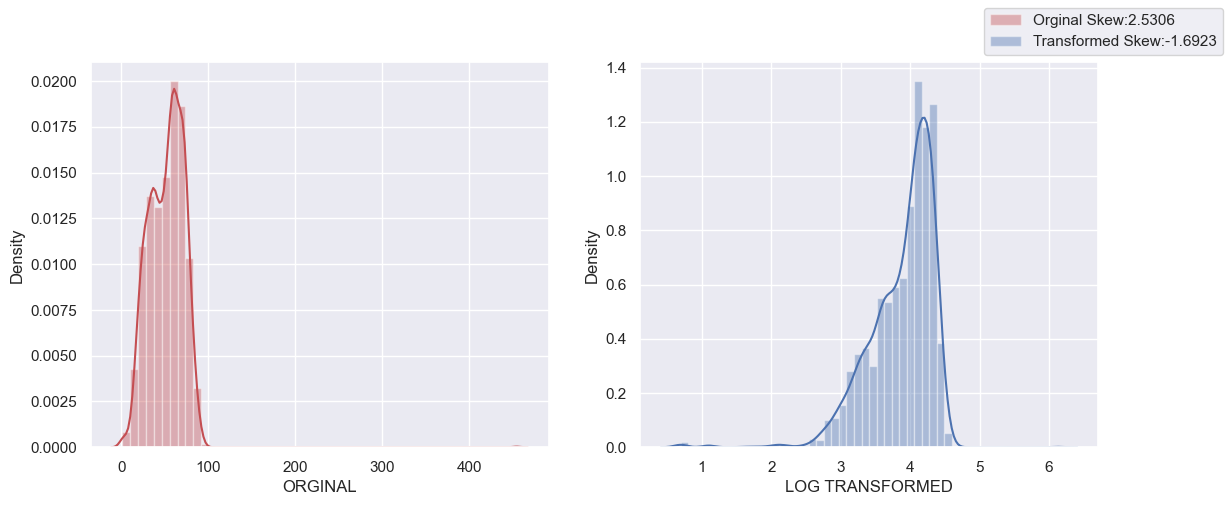

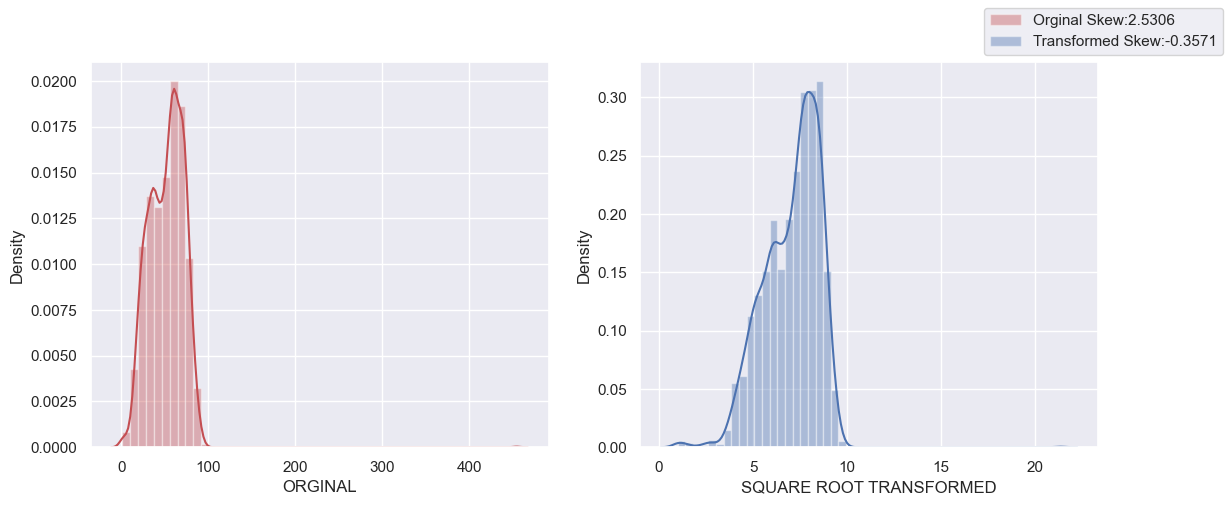

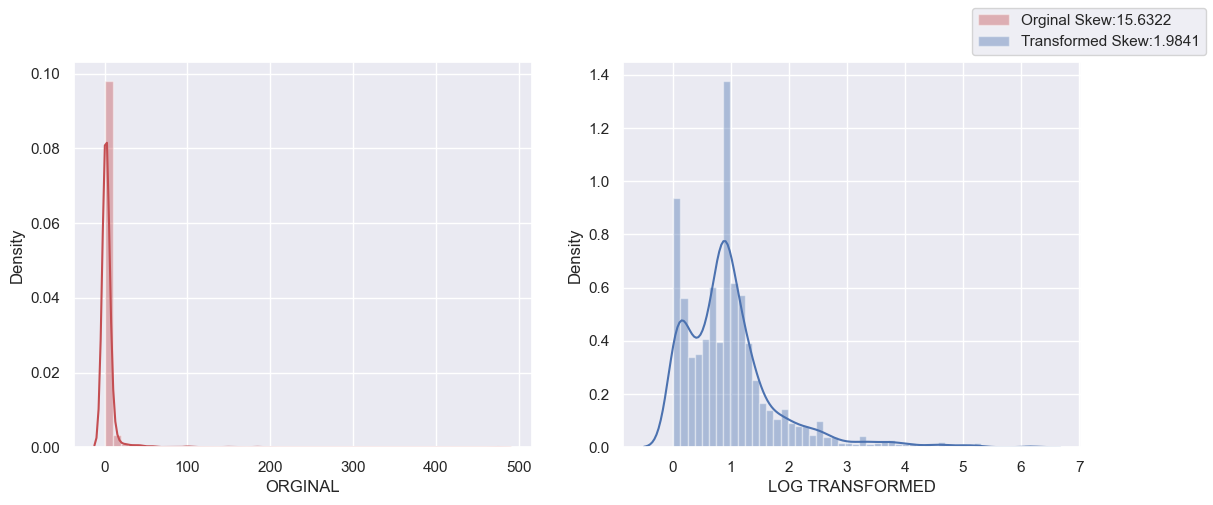

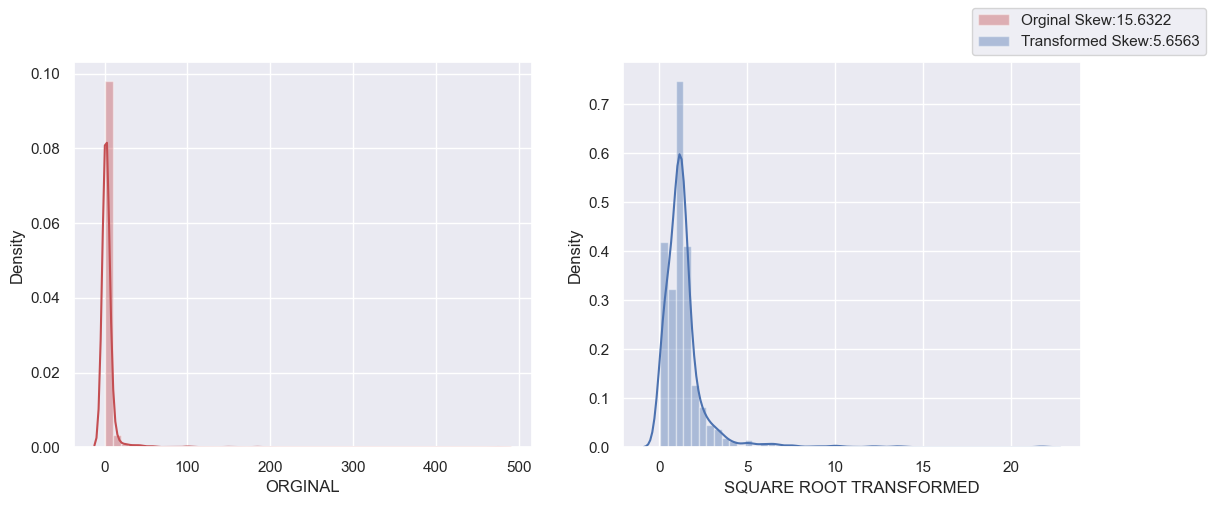

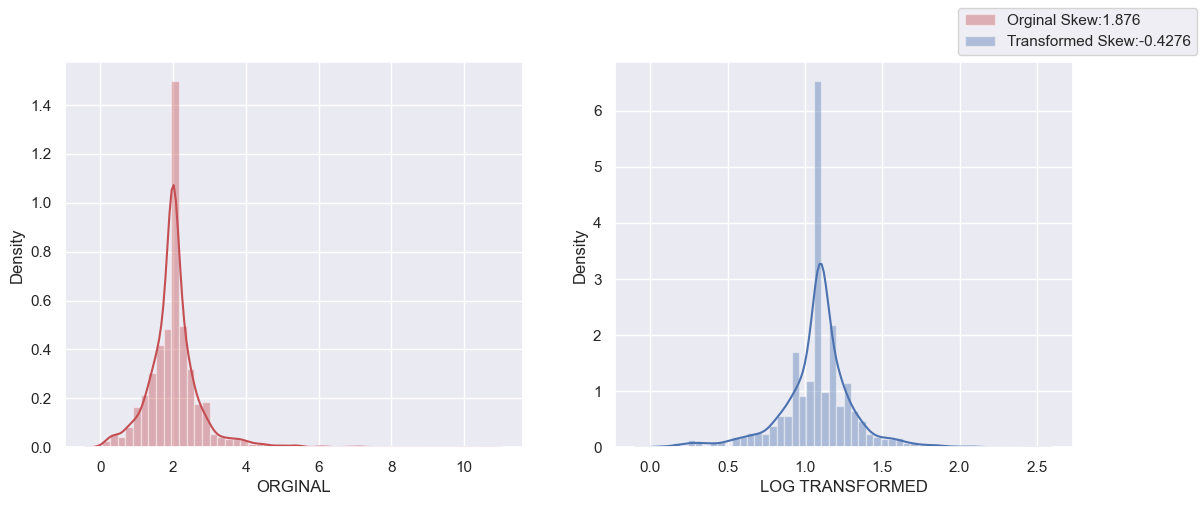

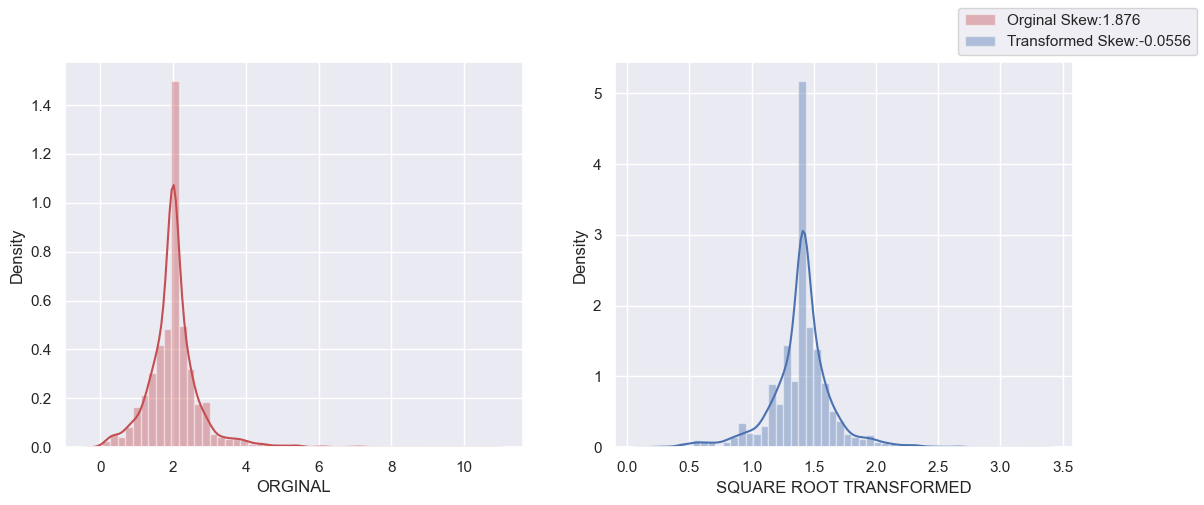

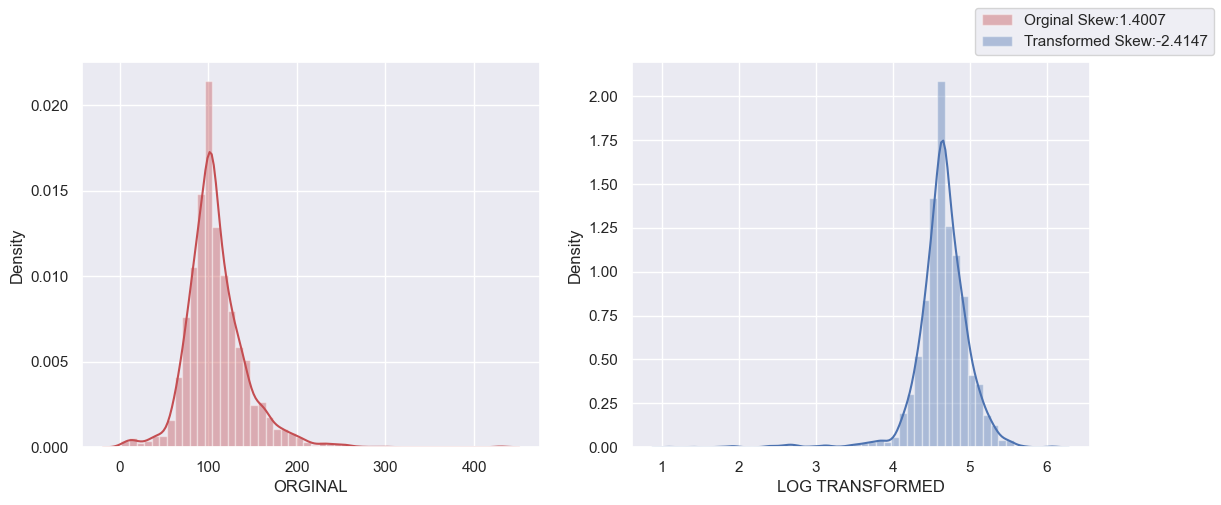

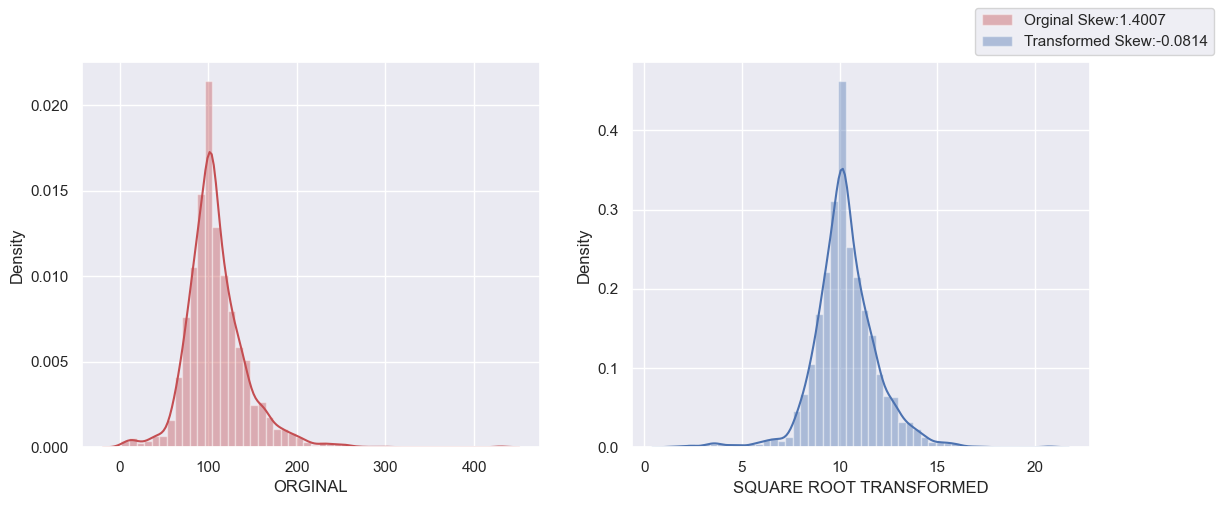

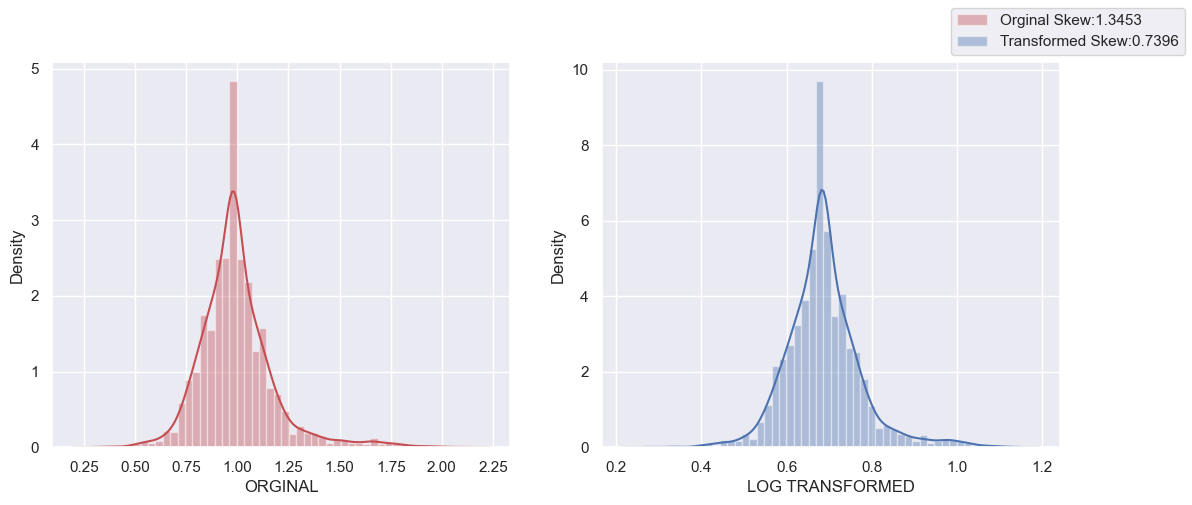

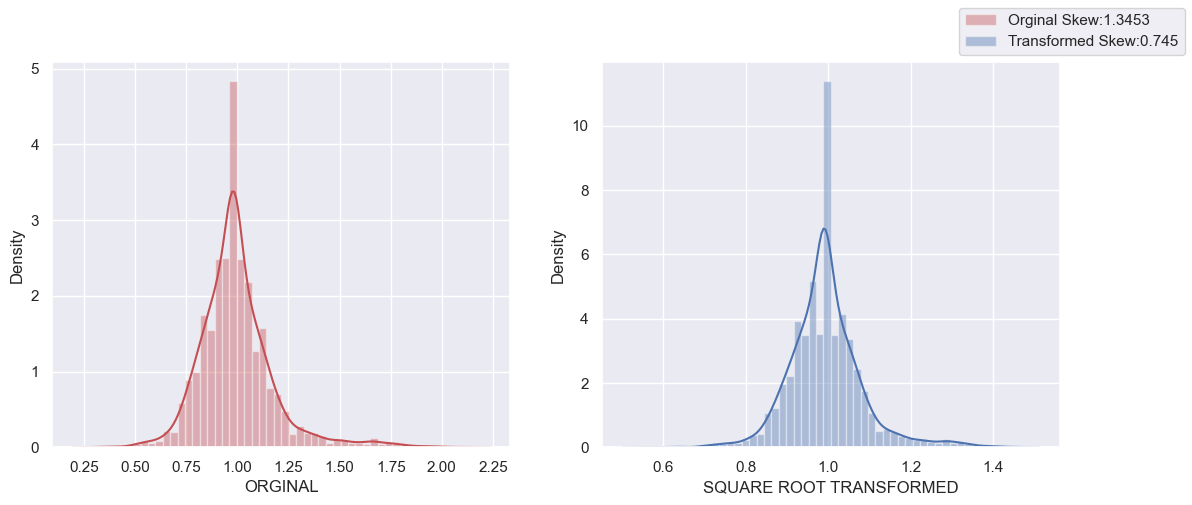

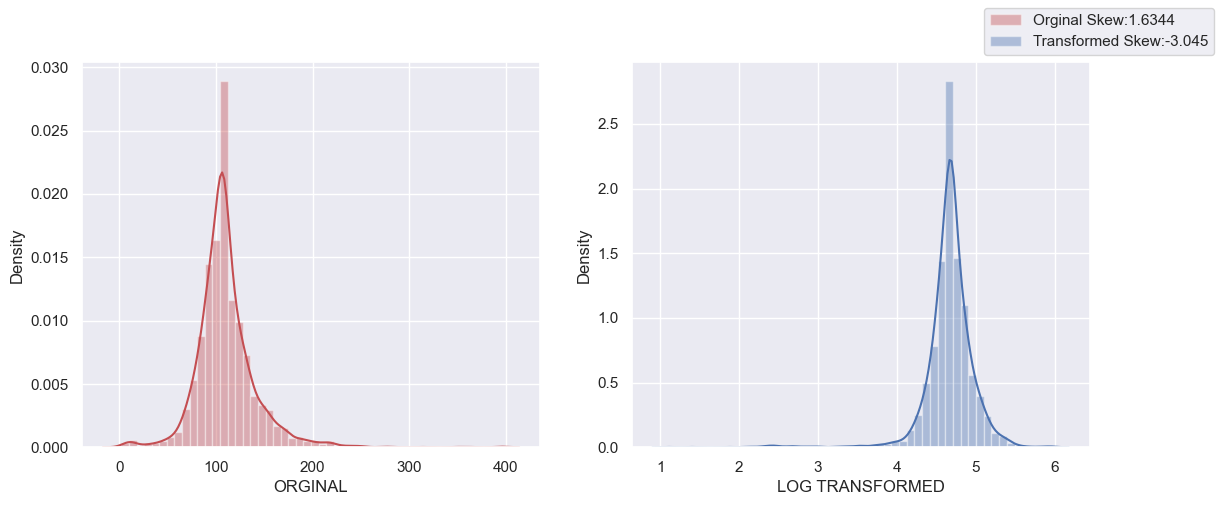

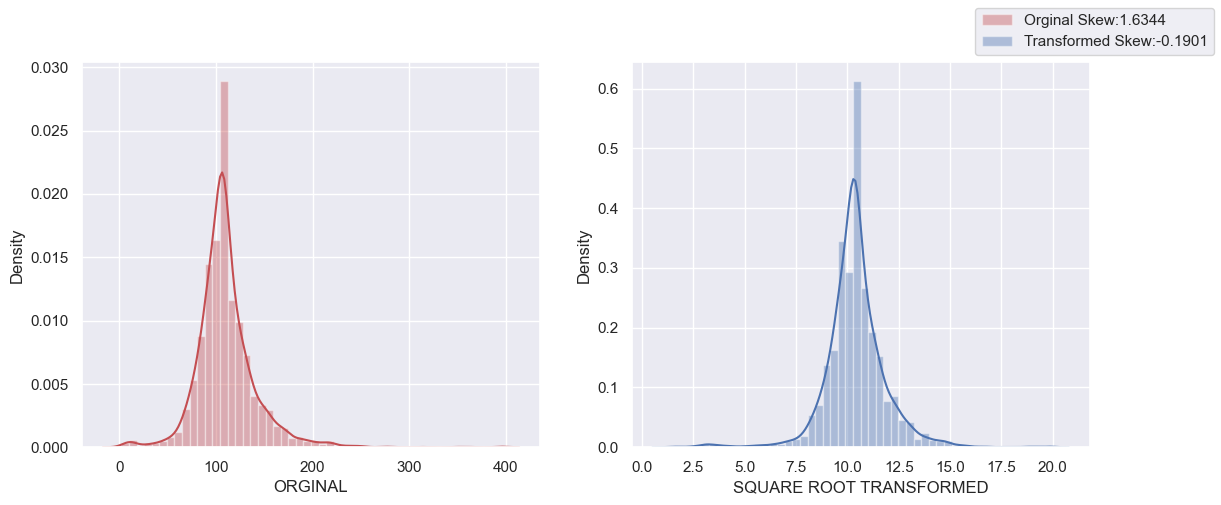

In [48]:

for i in df_filled[numerical_all]:
    
    print(" Plots after transformations for col : ",  i)   
    
    checkPlot(df_filled, i)



#### Observations:

- After Applying Transforamtion and Calculating the Skewness, we found best result for numerical features:
- Age: **SQRT**
- TSH: **LOG**
- T3:  **SQRT**
- TT4: **SQRT**
- T4U: **LOG**
- FTI: **SQRT**


In [49]:
df_transformed = df_filled.copy(deep = True)


#### Let's check first whether transformed columns are add in our dataset or not!!!

In [50]:
df_transformed.columns

# new column added in our dataset

Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'labels', 'log_age', 'sqrroot_age', 'log_TSH', 'sqrroot_TSH',
       'log_T3', 'sqrroot_T3', 'log_TT4', 'sqrroot_TT4', 'log_T4U',
       'sqrroot_T4U', 'log_FTI', 'sqrroot_FTI'],
      dtype='object')

In [51]:
df_transformed.shape


(2800, 34)

#### Since, only the above transforamtion are useful in our case, we will drop others

#### Now Dropping transformed columns which are not useful in our case

In [52]:
df_transformed.drop(['age', 'log_age', \
                     'TSH', 'sqrroot_TSH', \
                     'T3', 'log_T3', \
                     'TT4', 'log_TT4', \
                     'T4U', 'sqrroot_T4U', \
                     'FTI', 'log_FTI'], axis = 1, inplace = True)


In [53]:
df_transformed.columns


Index(['sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'labels', 'sqrroot_age',
       'log_TSH', 'sqrroot_T3', 'sqrroot_TT4', 'log_T4U', 'sqrroot_FTI'],
      dtype='object')

In [54]:
df_transformed.shape


(2800, 22)

##### Transformation END

Now we can do either Multi-collinearity part or Encoding first.

### So, Let's explore the Encoding part first


We do encoding to convert Categorical features into Numerical.

URLs:
- https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
- https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/

Let's extract the Categorical features.

In [55]:
df_transformed_cat = df_transformed.select_dtypes(include = ['object','category'])


In [56]:
df_transformed_cat.columns


Index(['sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'labels'],
      dtype='object')

In [57]:
df_transformed_cat.shape


(2800, 16)

#### Apply the One Hot Encoding

In [58]:
df_onehot_encoded = pd.get_dummies(df_transformed_cat.iloc[:,:-1], drop_first = True)


In [59]:
df_onehot_encoded.columns


Index(['sex_M', 'on thyroxine_t', 'query on thyroxine_t',
       'on antithyroid medication_t', 'sick_t', 'pregnant_t',
       'thyroid surgery_t', 'I131 treatment_t', 'query hypothyroid_t',
       'query hyperthyroid_t', 'lithium_t', 'goitre_t', 'tumor_t',
       'hypopituitary_t', 'psych_t'],
      dtype='object')

In case of Dummy Trap Problem:

- Refer this: https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/

In [60]:
df_onehot_encoded.shape


(2800, 15)

Now, let's do the label encoding on the target/labels columns (dependent feature)

In [61]:
df_transformed_label = pd.DataFrame(df_transformed_cat.iloc[:,-1])


In [62]:
df_transformed_label.head()

,labels
0,negative
1,negative
2,negative
3,negative
4,negative


In [63]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder_random_forest = preprocessing.LabelEncoder()
 
# Encode labels in column 'labels'.
df_transformed_label['labels']= label_encoder_random_forest.fit_transform(df_transformed_label)

# we will save the encoder as pickle to use when we do the prediction. We will need to decode the predcited values
# back to original

file = "label_encoder_random_forest.pickle"
pickle.dump(label_encoder_random_forest, open(file, "wb"))



In [64]:
df_transformed_label['labels'].unique()


array([2, 1, 0])

In [65]:
list (label_encoder_random_forest.inverse_transform([2, 1, 0]))

# ['negative', 'hypothyroid', 'hyperthyroid']

['negative', 'hypothyroid', 'hyperthyroid']

In [66]:
df_transformed_label.head()

,labels
0,2
1,2
2,2
3,2
4,2


In [67]:
df_onehot_encoded.head()


,sex_M,on thyroxine_t,query on thyroxine_t,on antithyroid medication_t,sick_t,pregnant_t,thyroid surgery_t,I131 treatment_t,query hypothyroid_t,query hyperthyroid_t,lithium_t,goitre_t,tumor_t,hypopituitary_t,psych_t
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's concatnate the categorical features with encoded label

In [68]:
df_encoded_cat = pd.concat([df_onehot_encoded, df_transformed_label], axis = 1)


In [69]:
df_encoded_cat.head()

# concatnation done

,sex_M,on thyroxine_t,query on thyroxine_t,on antithyroid medication_t,sick_t,pregnant_t,thyroid surgery_t,I131 treatment_t,query hypothyroid_t,query hyperthyroid_t,lithium_t,goitre_t,tumor_t,hypopituitary_t,psych_t,labels
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


##### Encoding END

### Multi-collinearity



Multi-collinearlity: One independent feature is **depend** on another independent feature.

So, it's a problem because independent feature should be independent **only** (not dependent)

Few suggestions from people:

- If we are using linear Model to solve problem, we have to deal with Multicollinearity
- And Linear models are Model which creates a line to predict or separate
- Example Linear Models: SVM, Logistic Regression, Linear Regression

- If you're going to solve using decision tree or any other tree model then no need to deal with Multicollinearity

- And to check Multicollinearity - Scatter plot, correlation and VIF (between independent features)

- For classification problems - checking independent vs dependent feature is not useful

- Multicollinearity is entirely for independent features


URLs:
- https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/
    
- https://online.stat.psu.edu/stat462/node/180/
    
- https://towardsdatascience.com/how-to-detect-and-deal-with-multicollinearity-9e02b18695f1
    
- https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

- https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

- https://www.datasklr.com/ols-least-squares-regression/multicollinearity

- https://cran.r-project.org/web/packages/olsrr/vignettes/regression_diagnostics.html

**Inferences:** We need to handle the Multi-collinearity

#### Let's check and handle the Multi-collinearity in Numerical features

In [70]:
df_numerical = df_transformed.select_dtypes(include = np.number)


In [71]:
df_numerical.head()


,sqrroot_age,log_TSH,sqrroot_T3,sqrroot_TT4,log_T4U,sqrroot_FTI
0,6.403124,0.832909,1.581139,11.180340,0.760806,10.440307
1,4.795832,1.629241,1.414214,10.099505,0.683097,10.344080
2,6.782330,0.683097,1.414214,10.440307,0.647103,10.954451
3,8.366600,0.148420,1.378405,13.228757,0.683097,10.344080
4,8.366600,0.542324,1.095445,7.810250,0.625938,8.366600


**Ways to check Multi-collinearity:** Scatter plot, Correlation and Variance Inflation Factor (VIF) - between independent features

**Can you calculate VIF for categorical variables?**
- VIF cannot be used on categorical data. Statistically speaking, it wouldn't make sense.
- If you want to check independence between 2 categorical variables you can however run a Chi-square test.

In [72]:
def calculate_vif(X):

    # Calculating VIF
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ]

    return(vif)

#### Some VIF Rules:

- VIF starts at 1 and has no upper limit

- VIF = 1, no correlation between the independent variable and the other variables

- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

- VIF = 1 → No correlation

- VIF = 1 to 5 → Moderate correlation

- VIF > 10 → High correlation

In [73]:
calculate_vif(df_numerical)


,variables,VIF
0,sqrroot_age,23.879352
1,log_TSH,3.341043
2,sqrroot_T3,49.171247
3,sqrroot_TT4,282.213577
4,log_T4U,112.040640
5,sqrroot_FTI,183.589494


#### Observations:
    
These features are having high correlation:
- sqrroot_age
- sqrroot_T3
- sqrroot_TT4
- log_T4U
- sqrroot_FTI

#### Now, let's handle this carefully. Explore what is happening in behind the scene of the VIF!

After googling, we found on article and it's mentioned:
- variance_inflation_factor expects the presence of a constant in the matrix of explanatory variables


URL: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

#### Let's deep dive what does it means?

First understood this:

- The statsmodel API assumes line passes through origin. Hence intercept is 0.

- In that case If we try to build a linear regression model using statsmodel model our intercept will always be 0.

- So, we externally have to tell statsmodel API that our intercept should not be 0. And that's why we have to add constant in our dataset.

- If we do linear regression via SKlib, then it internally add constant. But in statsmodel, we have to do this externally.


Now coming to VIF.

- Internally VIF is nothing but a Linear regression.

- So, in the backend, each independent model is predicted using other independent model.

- E.g. if we have X, Y, Z columns in the dataset.

- Y & Z are used as independent features and X become dependent feature.

- Similarly, X & Y will act as independent features. This 2 will predict Z.

- And similarly, X & Z will act as independent features. They 2 will predict Y.

- This means VIF is using Linear Regression and this VIF is present in statsmodel API.

- And in statsmodel API, we need to externally add a constant variable in the dataset.


##### Read above paragraphs for more clarification.

In [74]:
df_numerical_constant = df_numerical.copy(deep = True)


In [75]:
df_numerical_constant['constant'] = 1

## adding 1 constant in our dataset.

In [76]:
df_numerical_constant.head()


,sqrroot_age,log_TSH,sqrroot_T3,sqrroot_TT4,log_T4U,sqrroot_FTI,constant
0,6.403124,0.832909,1.581139,11.180340,0.760806,10.440307,1
1,4.795832,1.629241,1.414214,10.099505,0.683097,10.344080,1
2,6.782330,0.683097,1.414214,10.440307,0.647103,10.954451,1
3,8.366600,0.148420,1.378405,13.228757,0.683097,10.344080,1
4,8.366600,0.542324,1.095445,7.810250,0.625938,8.366600,1


In [77]:
calculate_vif(df_numerical_constant)


,variables,VIF
0,sqrroot_age,1.079170
1,log_TSH,1.420100
2,sqrroot_T3,1.608135
3,sqrroot_TT4,17.571336
4,log_T4U,6.915051
5,sqrroot_FTI,14.999932
6,constant,521.505157


We can see the VIF is significantly reduced after adding the constant value.

Now, let's analyze the above one by dropping the highest VIF value first.

In [78]:
df_numerical_constant.drop('sqrroot_TT4', axis = 1, inplace = True)


In [79]:
calculate_vif(df_numerical_constant)


,variables,VIF
0,sqrroot_age,1.078160
1,log_TSH,1.395940
2,sqrroot_T3,1.607507
3,log_T4U,1.410238
4,sqrroot_FTI,1.545203
5,constant,206.999885


#### Observations:
- Now we can see the VIF is significantly reduced after dropping the sqrroot_TT4 feature with highest VIF.
- And none of the features are correlated now.

This looks good.

#### Now, let's create the final dataset with numerical features by dropping the constant column

In [80]:
df_numerical_final = df_numerical_constant.drop('constant', axis = 1)


In [81]:
df_numerical_final.head()

# final dataset with numerical features

,sqrroot_age,log_TSH,sqrroot_T3,log_T4U,sqrroot_FTI
0,6.403124,0.832909,1.581139,0.760806,10.440307
1,4.795832,1.629241,1.414214,0.683097,10.344080
2,6.782330,0.683097,1.414214,0.647103,10.954451
3,8.366600,0.148420,1.378405,0.683097,10.344080
4,8.366600,0.542324,1.095445,0.625938,8.366600


#### Now, let's create the final dataset with categorical features

In [82]:
df_categorical_final = df_encoded_cat.copy(deep = True)


In [83]:
df_categorical_final.head()

# final dataset with categorical features

,sex_M,on thyroxine_t,query on thyroxine_t,on antithyroid medication_t,sick_t,pregnant_t,thyroid surgery_t,I131 treatment_t,query hypothyroid_t,query hyperthyroid_t,lithium_t,goitre_t,tumor_t,hypopituitary_t,psych_t,labels
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


#### Cancatenate the numerical and categorical features and create a final dataset

In [84]:
df_final = pd.concat([df_numerical_final, df_categorical_final], axis = 1)

# final dataset - 2800x21

In [85]:
df_final.head()


,sqrroot_age,log_TSH,sqrroot_T3,log_T4U,sqrroot_FTI,sex_M,on thyroxine_t,query on thyroxine_t,on antithyroid medication_t,sick_t,...,thyroid surgery_t,I131 treatment_t,query hypothyroid_t,query hyperthyroid_t,lithium_t,goitre_t,tumor_t,hypopituitary_t,psych_t,labels
0,6.403124,0.832909,1.581139,0.760806,10.440307,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,4.795832,1.629241,1.414214,0.683097,10.344080,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,6.782330,0.683097,1.414214,0.647103,10.954451,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,8.366600,0.148420,1.378405,0.683097,10.344080,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,8.366600,0.542324,1.095445,0.625938,8.366600,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [86]:
df_final.columns


Index(['sqrroot_age', 'log_TSH', 'sqrroot_T3', 'log_T4U', 'sqrroot_FTI',
       'sex_M', 'on thyroxine_t', 'query on thyroxine_t',
       'on antithyroid medication_t', 'sick_t', 'pregnant_t',
       'thyroid surgery_t', 'I131 treatment_t', 'query hypothyroid_t',
       'query hyperthyroid_t', 'lithium_t', 'goitre_t', 'tumor_t',
       'hypopituitary_t', 'psych_t', 'labels'],
      dtype='object')

In [87]:
# checking the total value of each target class
# negative - 2
# hyporthyroid - 1
# hyperthyroid - 0

df_final.labels.value_counts()


2    2503
1     220
0      77
Name: labels, dtype: int64

##### Multi-collinearity END

In [88]:
df_final.columns


Index(['sqrroot_age', 'log_TSH', 'sqrroot_T3', 'log_T4U', 'sqrroot_FTI',
       'sex_M', 'on thyroxine_t', 'query on thyroxine_t',
       'on antithyroid medication_t', 'sick_t', 'pregnant_t',
       'thyroid surgery_t', 'I131 treatment_t', 'query hypothyroid_t',
       'query hyperthyroid_t', 'lithium_t', 'goitre_t', 'tumor_t',
       'hypopituitary_t', 'psych_t', 'labels'],
      dtype='object')

In [89]:
df.columns


Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'labels'],
      dtype='object')

In [90]:
# renaming the column name

df_final.rename({'sqrroot_age': 'age', 'log_TSH': 'TSH', 'sqrroot_T3': 'T3', \
                 'log_T4U': 'T4U', 'sqrroot_FTI' : 'FTI', 'sex_M' : 'sex', \
                 'on thyroxine_t' : 'onthyroxine', 'query on thyroxine_t' : 'queryonthyroxine', \
                 'on antithyroid medication_t' : 'onantithyroidmedication', \
                 'sick_t' : 'sick', 'pregnant_t' : 'pregnant', 'thyroid surgery_t' : 'thyroidsurgery', \
                 'I131 treatment_t' : 'I131treatment', 'query hypothyroid_t' : 'queryhypothyroid', \
                 'query hyperthyroid_t' : 'queryhyperthyroid', 'lithium_t' : 'lithium', \
                 'goitre_t' : 'goitre', 'tumor_t' : 'tumor', 'hypopituitary_t' : 'hypopituitary', \
                 'psych_t' : 'psych'}, axis = 1, inplace = True)



In [91]:
df_final.head()


,age,TSH,T3,T4U,FTI,sex,onthyroxine,queryonthyroxine,onantithyroidmedication,sick,...,thyroidsurgery,I131treatment,queryhypothyroid,queryhyperthyroid,lithium,goitre,tumor,hypopituitary,psych,labels
0,6.403124,0.832909,1.581139,0.760806,10.440307,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,4.795832,1.629241,1.414214,0.683097,10.344080,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,6.782330,0.683097,1.414214,0.647103,10.954451,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,8.366600,0.148420,1.378405,0.683097,10.344080,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,8.366600,0.542324,1.095445,0.625938,8.366600,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [92]:
df_final.columns


Index(['age', 'TSH', 'T3', 'T4U', 'FTI', 'sex', 'onthyroxine',
       'queryonthyroxine', 'onantithyroidmedication', 'sick', 'pregnant',
       'thyroidsurgery', 'I131treatment', 'queryhypothyroid',
       'queryhyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
       'psych', 'labels'],
      dtype='object')

In [93]:
df_temp = df_final.copy(deep = True)


In [94]:
column_names = ["age", "sex", "TSH", "T3", "T4U", "FTI", \
                "onthyroxine", "queryonthyroxine", "onantithyroidmedication", \
                "sick", "pregnant", \
                "thyroidsurgery", "I131treatment", "queryhypothyroid", "queryhyperthyroid", \
                "lithium", "goitre", "tumor","hypopituitary","psych", "labels"]


In [95]:
# arranging the features in its origin sequence

df_final = df_final.reindex(columns = column_names)


In [96]:
df_final.columns


Index(['age', 'sex', 'TSH', 'T3', 'T4U', 'FTI', 'onthyroxine',
       'queryonthyroxine', 'onantithyroidmedication', 'sick', 'pregnant',
       'thyroidsurgery', 'I131treatment', 'queryhypothyroid',
       'queryhyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
       'psych', 'labels'],
      dtype='object')

In [97]:
# from pandas_profiling import ProfileReport


In [98]:
# profile = ProfileReport(df_final)
# profile

## ML Model Preparation

In [99]:
# first step is to seperate the independent and dependent features

# independent features i.e. all columns expect 'labels' are stored in 'X'
# dependent features i.e 'labels' column is stored in 'y'

X = df_final.drop('labels', axis = 1)
y = df_final['labels']


Now, we need to split our complete dataset into 'training' and 'testing'

In [100]:
# spliting the dataset into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 109) 

# 70% for training and 30% for testing (this is not a hard rule)


Now before proceedind further we need to check whether our Train dataset is balanced or not.

If not balanced, then we should balance it first.

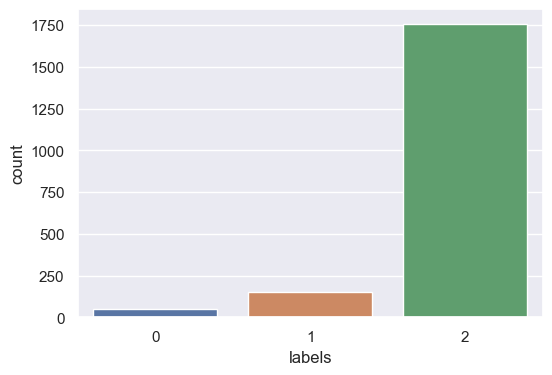

In [101]:
# Sets the figure size temporarily but has to be set again the next plot

plt.figure(figsize = (6,4))

# checking the  label class distribution

sns.countplot(y_train)

plt.show()


From the above plot, we can say our dataset is highly imbalanced.

Let's balance it first.

#### So to handle the imbalanced data, we have multiple techniques:

URLs:
- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
- https://datascience.foundation/sciencewhitepaper/understanding-imbalanced-datasets-and-techniques-for-handling-them
- https://towardsdatascience.com/dealing-with-imbalanced-dataset-642a5f6ee297
- https://www.topcoder.com/thrive/articles/How%20to%20Handle%20Imbalanced%20Dataset
- https://www.kaggle.com/dskagglemt/handling-imbalance-class
- https://datascience.foundation/sciencewhitepaper/understanding-imbalanced-datasets-and-techniques-for-handling-them


#### Sampling Methods-
- SMOTE 
- Oversampling- Adasyn
- Under Sampling

NOTE: We should do the train_test_split first and then sampling on TRAIN data only (we already did).

In [102]:
# there are multiple sampling_startegy, select according to use-case

smote = SMOTE(sampling_strategy = 'auto')

X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)


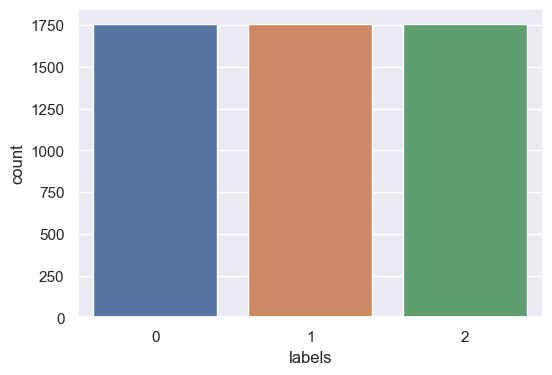

In [103]:
# Sets the figure size temporarily but has to be set again the next plot

plt.figure(figsize = (6,4))

# checking the sampled label class distribution

sns.countplot(y_train_sampled)

plt.show()


#### Observation:
- Now the dataset is balanced. Hurray :)

### Everything looks good, now we apply the machine learning algorithm

In [104]:
X_train.shape

(1960, 20)

In [105]:
y_train.shape

(1960,)

In [106]:
X_train_sampled.shape

(5271, 20)

In [107]:
y_train_sampled.shape

(5271,)

In [108]:
X_test.shape

(840, 20)

In [109]:
y_test.shape

(840,)

### Random Forest Classifier

#### Fitting the model on Train Data and checking the performance

In [110]:
# importing the important libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# create an instance of a Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

# training the Random Forest model on the sampled train dataset
random_forest_model.fit(np.array(X_train_sampled), y_train_sampled)

# pedicting the labels on the test set
y_predicted_randomforest = random_forest_model.predict(np.array(X_test))



In [111]:
# import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# calculating the accuracy on train data
print('Accuracy Score on train data: ', metrics.accuracy_score(y_true = y_train_sampled,\
                                                               y_pred = random_forest_model.predict(X_train_sampled)))

# calculating the accuracy on test data
print('Accuracy Score on test data: ', metrics.accuracy_score(y_true = y_test, y_pred = y_predicted_randomforest))



Accuracy Score on train data:  0.9992411307152343
Accuracy Score on test data:  0.975


#### Performance Parameters

In [112]:
print("****** Random Forest Model Prediction on Test Data ******")
print("*********************************************************\n")
print("--------- Confusion Matrix ---------\n\n", confusion_matrix(y_test, y_predicted_randomforest))
print("\n------------------------------------")
print("Acurracy Score:", accuracy_score(y_test, y_predicted_randomforest))
print("------------------------------------")
print("\n------ Classification Report -------\n\n", classification_report(y_test, y_predicted_randomforest))
print("--------------------------------------------------------")

****** Random Forest Model Prediction on Test Data ******
*********************************************************

--------- Confusion Matrix ---------

 [[ 24   0   2]
 [  0  68   0]
 [ 15   4 727]]

------------------------------------
Acurracy Score: 0.975
------------------------------------

------ Classification Report -------

               precision    recall  f1-score   support

           0       0.62      0.92      0.74        26
           1       0.94      1.00      0.97        68
           2       1.00      0.97      0.99       746

    accuracy                           0.97       840
   macro avg       0.85      0.97      0.90       840
weighted avg       0.98      0.97      0.98       840

--------------------------------------------------------


#### Observations

On Training Dataset, we are getting good accuracy **(99.92%)**, Precision, Recall and F-score.

Also, on Testing data, we are getting accuracy: **96.90%**.

#### Let's save this model into a pickle file format

In [113]:
# model saving

import pickle

pickle.dump(random_forest_model, open("random_forest_model.pkl","wb"))
